# Download libraries

In [1]:
!pip install ipywidgets findspark pandas requests seaborn IPython flask requests_oauthlib pytz tweepy statsmodels plotly wordcloud textblob nltk requests_oauthlib flask pyspark dask textblob sklearn
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Importing libraries

In [2]:
# Data Manipulation and Analysis
import pandas as pd
import dask.dataframe as dd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# File and Directory Operations
import os
import csv

# Date and Time Handling
import datetime
from datetime import datetime, timedelta
import time
from pytz import timezone

# System-related
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import sys
import socket
from io import BytesIO
import subprocess

# Twitter API
import tweepy
import json
import requests_oauthlib

# Plotting and Visualization
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import matplotlib.font_manager as fm

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Logging
import logging

# Spark
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SQLContext, SparkSession
import findspark

# Web Development (Flask)
from flask import Flask, jsonify, request, render_template
from IPython.display import IFrame, display, update_display
import ipywidgets as widgets

# Other Dependencies
import ast
import re
import warnings
import requests
from tqdm.auto import tqdm
from tqdm import tqdm
import shutil
import threading
import concurrent.futures

# Loading the credentials

In [3]:
try:
    # Load the Twitter API credentials from the config file
    with open('config.json', 'r') as f:
        config = json.load(f)
        consumer_key = config['consumer_key']
        consumer_secret = config['consumer_secret']
        access_token = config['access_token']
        access_token_secret = config['access_token_secret']

    # Verify the Twitter API credentials
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    try:
        api = tweepy.API(auth, wait_on_rate_limit=True)
        user = api.verify_credentials()
        logging.info("Twitter API connection successful.")
    except tweepy.error.TweepError as e:
        logging.error("Error: Failed to verify Twitter API credentials.")
        logging.error(str(e))

except FileNotFoundError:
    logging.error("Error: The config file 'config.json' does not exist.")

except json.JSONDecodeError as e:
    logging.error("Error: Failed to load Twitter API credentials from 'config.json'.")
    logging.error(str(e))

except Exception as e:
    logging.error("An error occurred during a Twitter API connection.")
    logging.error(str(e))

# Disabling warnings

In [4]:
warnings.filterwarnings("ignore")

# Logger

In [5]:
# Get today's date
today = datetime.now().date()

# Create a log file with today's date in the name
log_file = f"TwitterAPI_{today}.log"

# Configure the root logger
logging.basicConfig(level=logging.INFO)

# Create a FileHandler and set its formatter
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s','%Y-%m-%d %H:%M:%S'))

# Attach the FileHandler to the root logger
logging.getLogger().addHandler(file_handler)

# Downloading and save twitter data
The free tier of the twitter API holds the limitation of:</br>
<b>**7 Day tweet history limit </br>
**1500 tweet request limit per 900sec circ. </b>

In [6]:
# Function to fetch tweets for a given query and date range
def fetch_tweets(query, start_date, end_date):
    tweets = []
    for tweet in tweepy.Cursor(api.search_tweets, q=query, lang='en', tweet_mode='extended').items(150):
        tweet_date = tweet.created_at.date()
        if start_date.date() <= tweet_date <= end_date.date():
            tweets.append({
                'Date': tweet_date,
                'Tweet': tweet.full_text,
                'User_Location': tweet.user.location
            })
    return tweets

# Define the topic and initial date range
topic = "(ios OR apple OR AAPL OR iphone OR ipad)"
start_date = datetime.today() - timedelta(days=91)

# Initialize an empty DataFrame for existing data
df_existing = pd.DataFrame()

# Create a loop to run for 91 days
progress_widget = widgets.IntProgress(value=0, min=0, max=91, description='Progress:', style={'bar_color': 'blue'})
display(progress_widget)

for _ in range(91):
    # Calculate the end date for the current iteration
    end_date = start_date + timedelta(days=1)
    
    # Format the dates as strings
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    
    # Define the search query with the current date range
    query = f"{topic} until:{end_date_str} since:{start_date_str}"
    
    try:
        # Check if the CSV file already exists and has records
        if os.path.isfile('tweets.csv') and os.stat('tweets.csv').st_size > 0:
            # Read the existing data from the CSV file
            try:
                df_existing = pd.read_csv('tweets.csv')
                
                # Check if the existing DataFrame is empty or does not have the 'Date' column
                if df_existing.empty or 'Date' not in df_existing.columns:
                    df_existing = pd.DataFrame()
                
            except pd.errors.EmptyDataError:
                # Handle the case when the CSV file is empty
                df_existing = pd.DataFrame()
            
            if (not df_existing.empty) and ('Date' in df_existing.columns):
                # Check if the CSV file already has records for the current date range
                try:
                    existing_dates = pd.to_datetime(df_existing['Date']).dt.date
                    if (existing_dates >= start_date.date()).any() and (existing_dates <= end_date.date()).any():
                        logging.info("Skipping download for the date range: {} to {} (CSV file already has records).".format(start_date_str, end_date_str))
                        # Update the start date for the next iteration
                        start_date = end_date
                        # Update the progress bar
                        progress_widget.value += 1
                        continue
                except ValueError:
                    # Handle the case when there are non-date strings in the 'Date' column
                    df_existing = pd.DataFrame()
        
        # Fetch tweets on the specified topic and date range using multithreading
        tweets = fetch_tweets(query, start_date, end_date)
        
        if len(tweets) > 0:
            msg = "Tweets downloaded successfully for the date range: {} to {}"
            logging.info(msg.format(start_date_str, end_date_str))
            
            # Convert the tweets list into a DataFrame
            df_new = pd.DataFrame(tweets)
            
            # Save the new DataFrame to a new CSV file
            df_new.to_csv('tweets.csv', index=False)
            logging.info("New CSV file created with the downloaded tweets.")
        else:
            msg = "No tweets found for the date range: {} to {}"
            logging.info(msg.format(start_date_str, end_date_str))
    
    except tweepy.TweepyException as e:
        if e.api_code == 88:
            # Rate limit reached, wait for the specified duration
            wait_time = int(e.response.headers['Retry-After'])
            msg = "Rate limit reached. Sleeping for: {} seconds."
            logging.info(msg.format(wait_time))
            time.sleep(wait_time)
        else:
            logging.error("Error: Failed to download tweets.")
            logging.error(e)
    
    # Update the start date for the next iteration
    start_date = end_date
    
    # Update the progress bar
    progress_widget.value += 1

# Close the progress bar
progress_widget.close()

# Log the execution of the tweet downloading process
logging.info("Tweet downloading process completed.")


IntProgress(value=0, description='Progress:', max=91, style=ProgressStyle(bar_color='blue'))

# Log data

In [7]:
# Read the log file into a DataFrame
log_df = pd.read_csv(log_file, sep=":", names=["Timestamp","Type","Message","Sleep"])

# Define the CSV file name for saving the log DataFrame
csv_file = f"TwitterAPI_{today}.csv"

# Check if the CSV file already exists
if os.path.isfile(csv_file):
    # Append the log DataFrame to the existing CSV file
    log_df.to_csv(csv_file, mode='a', header=False, index=False)
else:
    # Save the log DataFrame to a new CSV file
    log_df.to_csv(csv_file, index=False)

# Display the log DataFrame
log_df

Timestamp  Type                                          Message  Sleep
0  2023-05-26 23    14  42 - WARNING - Rate limit reached. Sleeping for    823
1  2023-05-26 23    29  30 - WARNING - Rate limit reached. Sleeping for    836

# Cleaning tweets

In [8]:
# Load the tweets data from the CSV file
df_tweets = pd.read_csv('tweets.csv')

# Convert the 'Tweet' column to string type
df_tweets['Tweet'] = df_tweets['Tweet'].astype(str)

# Compile the regular expressions
remove_chars_regex = re.compile(r'[^\w\s]')
remove_links_regex = re.compile(r'http\S+|www\S+')
remove_usernames_regex = re.compile(r'@[^\s]+')

# Function to clean a single tweet
def clean_tweet(tweet):
    # Remove unnecessary characters and links
    cleaned_tweet = remove_chars_regex.sub('', tweet)
    cleaned_tweet = remove_links_regex.sub('', cleaned_tweet)

    # Remove Twitter usernames
    cleaned_tweet = remove_usernames_regex.sub('', cleaned_tweet)

    # Remove non-English words
    cleaned_words = []
    english_words = set(words.words())
    for word in cleaned_tweet.split():
        if word.lower() in english_words:
            cleaned_words.append(word)
    cleaned_tweet = ' '.join(cleaned_words)

    return cleaned_tweet

# Clean the tweets column using tqdm for progress bar
cleaned_tweets = []
total_tweets = len(df_tweets)
progress_bar = widgets.IntProgress(min=0, max=total_tweets, description='Cleaning:')
display(progress_bar)
for i, tweet in tqdm(enumerate(df_tweets['Tweet']), total=total_tweets):
    cleaned_tweet = clean_tweet(tweet)
    cleaned_tweets.append(cleaned_tweet)
    progress_bar.value = i + 1
progress_bar.close()

# Update the 'Tweet' column with cleaned tweets
df_tweets['Tweet'] = cleaned_tweets

# Remove rows with empty tweet values
df_tweets = df_tweets.dropna(subset=['Tweet'])

# Save the cleaned tweets back to the CSV file
df_tweets.to_csv('tweets_cleaned.csv', index=False)

# Log the execution of the tweet cleaning process
print("Tweet cleaning process completed.")

IntProgress(value=0, description='Cleaning:', max=150)

100%|█████████████████████████████████████████| 150/150 [00:12<00:00, 12.22it/s]

Tweet cleaning process completed.


# Tweet EDA

Number of tweets: 150
Columns: Index(['Date', 'Tweet', 'User_Location'], dtype='object')
Sample tweets:
        Date                                              Tweet  User_Location
0 2023-05-25  RT @drdave1999: A Texas high school had to pos...  Calabasas, CA
1 2023-05-25  RT @thomasmay_eth: The #Refund airdrop is Endi...            NaN
2 2023-05-25  RT @iHad2GoGetit: Ngl Apple not giving us a ch...            NaN
3 2023-05-25  RT @thomasmay_eth: The #Refund airdrop is Endi...            NaN
4 2023-05-25  RT @ProjectLincoln: When elected officials are...          World


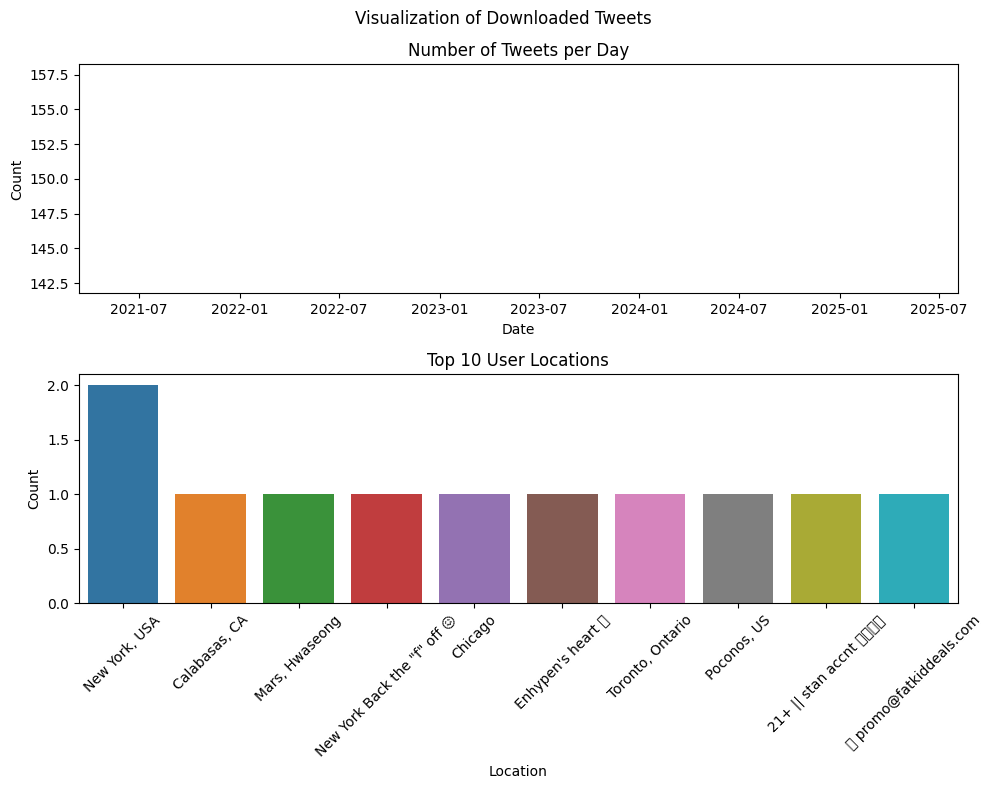

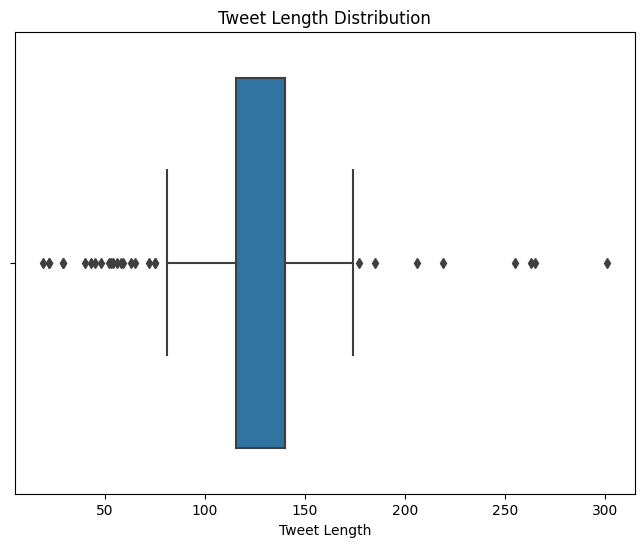

In [9]:
# Read the tweets data from the CSV file
df_tweets = pd.read_csv('tweets.csv')

# Convert the 'Date' column to datetime, handling invalid dates
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'], errors='coerce')

# Perform basic exploratory data analysis (EDA)
print("Number of tweets:", len(df_tweets))
print("Columns:", df_tweets.columns)
print("Sample tweets:")
print(df_tweets.head())

# Visualize the downloaded tweets

# Create a grouped subplot for visualizations
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
fig.suptitle('Visualization of Downloaded Tweets')

# Plot 1: Number of tweets per day
tweets_per_day = df_tweets['Date'].value_counts().sort_index()
sns.lineplot(x=tweets_per_day.index, y=tweets_per_day.values, ax=axes[0])
axes[0].set_title('Number of Tweets per Day')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count')

# Plot 2: Top 10 user locations
top_locations = df_tweets['User_Location'].value_counts().head(10)
sns.barplot(x=top_locations.index, y=top_locations.values, ax=axes[1])
axes[1].set_title('Top 10 User Locations')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

# Clean the 'Tweet' column by removing missing values
df_tweets_cleaned = df_tweets.dropna(subset=['Tweet'])

# Visualize the tweet length distribution using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_tweets_cleaned['Tweet'].apply(len))
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.show()

# Sentiment analysis

In [10]:
try:
    # Load the tweets from the CSV file
    df = pd.read_csv('tweets.csv')

    # Convert 'Tweet' column to string type
    df['Tweet'] = df['Tweet'].astype(str)

    # Define and remove stopwords
    stop_words = set(stopwords.words('english'))

    # Function for sentiment analysis and stopwords removal
    def analyze_sentiment(tweet):
        # Remove stopwords
        cleaned_tweet = ' '.join([word for word in tweet.split() if word.lower() not in stop_words])

        # Perform sentiment analysis using TextBlob
        sentiment = TextBlob(cleaned_tweet).sentiment.polarity

        # Classify sentiment as positive, negative, or neutral
        sentiment_label = 'Positive' if sentiment > 0 else 'Negative' if sentiment < 0 else 'Neutral'

        return sentiment, sentiment_label

    # Function for multithreaded sentiment analysis
    def multithreaded_sentiment_analysis(tweet):
        sentiment, sentiment_label = analyze_sentiment(tweet)
        return sentiment, sentiment_label

    # Perform sentiment analysis using multithreading
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(multithreaded_sentiment_analysis, df['Tweet']))

    # Extract sentiment and sentiment_label from the results
    sentiments, sentiment_labels = zip(*results)

    # Update the DataFrame with sentiment and sentiment_label columns
    df['sentiment'] = sentiments
    df['sentiment_label'] = sentiment_labels

    # Save the updated DataFrame to CSV
    df.to_csv('tweets_sentiment.csv', index=False)

except EmptyDataError:
    # Handle the case when the CSV file is empty
    logging.error("Error: The CSV file is empty.")

except FileNotFoundError:
    # Handle the case when the CSV file is not found
    logging.error("Error: The CSV file 'tweets.csv' does not exist.")

except Exception as e:
    # Handle any other exceptions that may occur
    logging.error("An error occurred during sentiment analysis and classification.")
    logging.error(str(e))

# Time series forecast of the sentiment

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22531D-01    |proj g|=  1.86492D-02

At iterate    5    f= -2.22679D-01    |proj g|=  5.58526D-03

At iterate   10    f= -2.22710D-01    |proj g|=  1.55853D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   2.746D-05  -2.227D-01
  F = -0.22271177865854230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


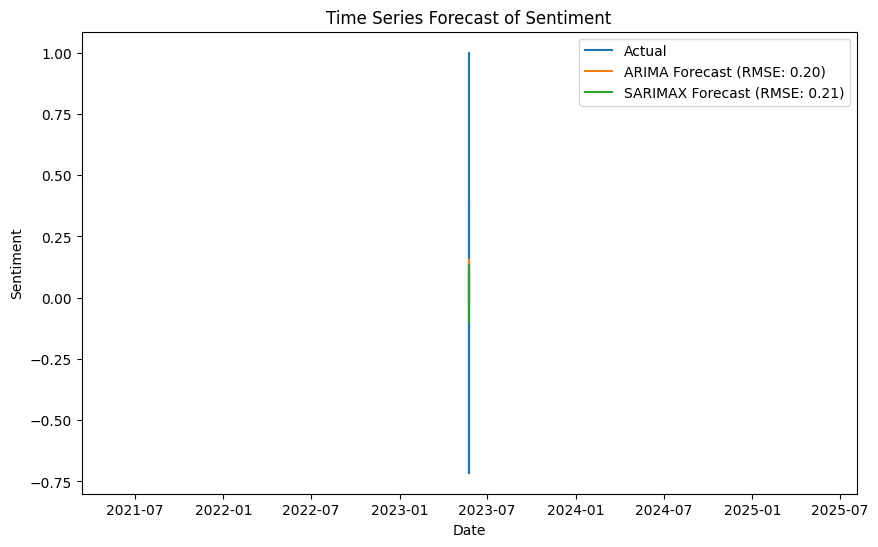

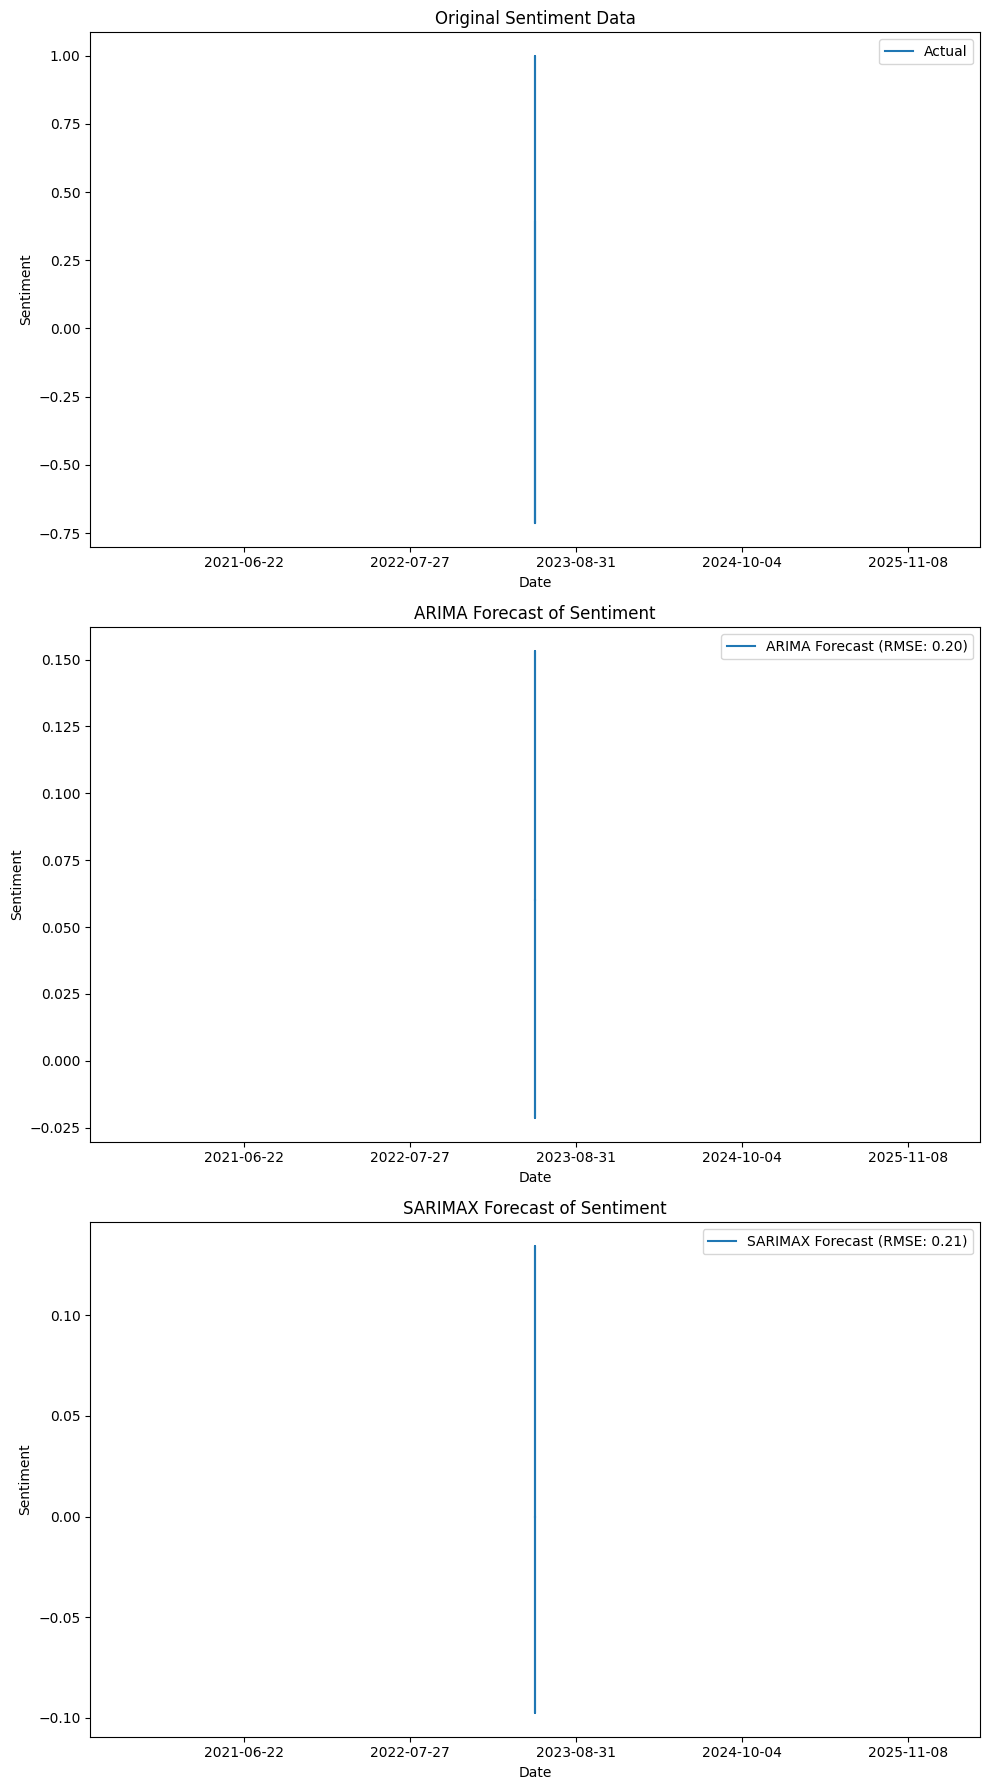

In [11]:
# Load the tweet sentiment data from the CSV file
df = pd.read_csv('tweets_sentiment.csv', parse_dates=['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Ensure the index of test_data is a datetime index and sorted
test_data.index = pd.to_datetime(test_data.index)
test_data = test_data.sort_index()

# Define the model configurations
arima_order = (1, 0, 1)
sarimax_order = (1, 0, 1)

# Initialize the models
arima_model = ARIMA(train_data['sentiment'], order=arima_order).fit()
sarimax_model = SARIMAX(train_data['sentiment'], order=sarimax_order).fit()

# Generate predictions for the entire dataset
arima_predictions = arima_model.predict(start=0, end=len(df)-1, dynamic=False)
sarimax_predictions = sarimax_model.predict(start=0, end=len(df)-1)

# Evaluate model performance
arima_rmse = mean_squared_error(df['sentiment'], arima_predictions, squared=False)
sarimax_rmse = mean_squared_error(df['sentiment'], sarimax_predictions, squared=False)

# Create Plotly figure for the original plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual sentiment data
ax.plot(df.index, df['sentiment'], label='Actual')

# Plot forecasted sentiment data
ax.plot(df.index, arima_predictions, label=f'ARIMA Forecast (RMSE: {arima_rmse:.2f})')
ax.plot(df.index, sarimax_predictions, label=f'SARIMAX Forecast (RMSE: {sarimax_rmse:.2f})')

# Set plot labels and legend
ax.set_title('Time Series Forecast of Sentiment')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.legend()

# Create subplots for each model's visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Set the desired number of x-axis tick labels
max_xticks = 7

# Plot original data
axs[0].plot(df.index, df['sentiment'], label='Actual')
axs[0].set_title('Original Sentiment Data')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Sentiment')
axs[0].legend()
axs[0].xaxis.set_major_locator(plt.MaxNLocator(max_xticks))

# Plot ARIMA forecast
axs[1].plot(df.index, arima_predictions, label=f'ARIMA Forecast (RMSE: {arima_rmse:.2f})')
axs[1].set_title('ARIMA Forecast of Sentiment')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Sentiment')
axs[1].legend()
axs[1].xaxis.set_major_locator(plt.MaxNLocator(max_xticks))

# Plot SARIMAX forecast
axs[2].plot(df.index, sarimax_predictions, label=f'SARIMAX Forecast (RMSE: {sarimax_rmse:.2f})')
axs[2].set_title('SARIMAX Forecast of Sentiment')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Sentiment')
axs[2].legend()
axs[2].xaxis.set_major_locator(plt.MaxNLocator(max_xticks))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [12]:
# Generate 1-week, 1-month, and 3-month forecasts using the SARIMAX model
forecast_1w = sarimax_model.get_forecast(steps=7)
forecast_1m = sarimax_model.get_forecast(steps=30)
forecast_3m = sarimax_model.get_forecast(steps=90)

# Get the forecasted mean values
forecast_1w_mean = forecast_1w.predicted_mean
forecast_1m_mean = forecast_1m.predicted_mean
forecast_3m_mean = forecast_3m.predicted_mean

# Create a DataFrame for the forecast data
forecast_df = pd.DataFrame({
    '1 Week Forecast': forecast_1w_mean,
    '1 Month Forecast': forecast_1m_mean,
    '3 Months Forecast': forecast_3m_mean
})

# Format the DataFrame for better readability
formatted_forecast_df = forecast_df.applymap('{:.2f}'.format)

# Display the formatted forecast DataFrame
print("Forecasted Sentiment:")
print(formatted_forecast_df)

Forecasted Sentiment:
    1 Week Forecast 1 Month Forecast 3 Months Forecast
120           -0.09            -0.09             -0.09
121            0.05             0.05              0.05
122           -0.03            -0.03             -0.03
123            0.01             0.01              0.01
124           -0.01            -0.01             -0.01
..              ...              ...               ...
205             nan              nan              0.00
206             nan              nan             -0.00
207             nan              nan              0.00
208             nan              nan             -0.00
209             nan              nan              0.00

[90 rows x 3 columns]


# Sentiment EDA

In [13]:
# Read the tweets data from the CSV file
df_tweets = pd.read_csv('tweets_sentiment.csv')

# Perform basic exploratory data analysis (EDA)
print("Basic Exploratory Data Analysis:")
print("--------------------------------")
print(f"Number of tweets: {len(df_tweets):,}")
print("\n Columns:")
for column in df_tweets.columns:
    print(f" - {column}")
df_tweets.head(5)

Basic Exploratory Data Analysis:
--------------------------------
Number of tweets: 150

 Columns:
 - Date
 - Tweet
 - User_Location
 - sentiment
 - sentiment_label


Date                                              Tweet   
0  2023-05-25  RT @drdave1999: A Texas high school had to pos...  \
1  2023-05-25  RT @thomasmay_eth: The #Refund airdrop is Endi...   
2  2023-05-25  RT @iHad2GoGetit: Ngl Apple not giving us a ch...   
3  2023-05-25  RT @thomasmay_eth: The #Refund airdrop is Endi...   
4  2023-05-25  RT @ProjectLincoln: When elected officials are...   

   User_Location  sentiment sentiment_label  
0  Calabasas, CA   0.390625        Positive  
1            NaN   0.000000         Neutral  
2            NaN   0.000000         Neutral  
3            NaN   0.000000         Neutral  
4          World   0.000000         Neutral

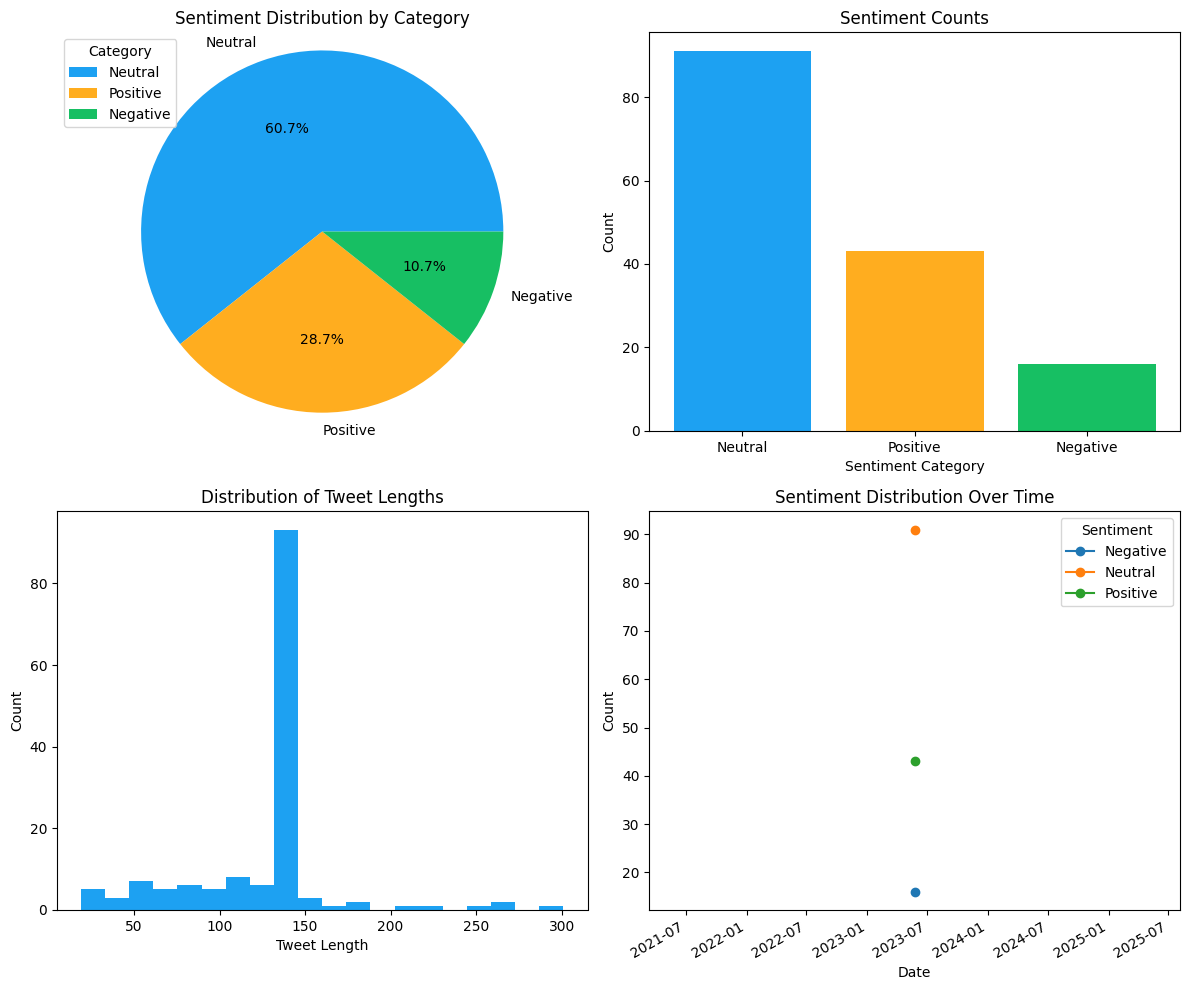

In [14]:
# Calculate the counts of sentiment labels
sentiment_label_counts = df_tweets['sentiment_label'].value_counts()

# Define the Twitter UI inspired color palette
color_palette = ['#1DA1F2', '#FFAD1F', '#17BF63']  

# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Pie chart for sentiment distribution
axes[0, 0].pie(sentiment_label_counts, labels=sentiment_label_counts.index, autopct='%1.1f%%', colors=color_palette)
axes[0, 0].set_title('Sentiment Distribution by Category')
axes[0, 0].legend(title='Category')
axes[0, 0].axis('equal')

# Plot 2: Bar chart for sentiment counts
axes[0, 1].bar(sentiment_label_counts.index, sentiment_label_counts, color=color_palette)
axes[0, 1].set_title('Sentiment Counts')
axes[0, 1].set_xlabel('Sentiment Category')
axes[0, 1].set_ylabel('Count')

# Plot 3: Histogram of tweet lengths
axes[1, 0].hist(df_tweets['Tweet'].str.len(), bins=20, color='#1DA1F2')
axes[1, 0].set_title('Distribution of Tweet Lengths')
axes[1, 0].set_xlabel('Tweet Length')
axes[1, 0].set_ylabel('Count')

# Plot 4: Line chart of sentiment distribution over time
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'], errors='coerce')
df_sentiment_counts = df_tweets.groupby(['Date', 'sentiment_label']).size().unstack()
df_sentiment_counts.plot(ax=axes[1, 1], marker='o')
axes[1, 1].set_title('Sentiment Distribution Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Sentiment')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Most frequent words by sentiment

In [15]:
# Preprocess tweets by filling missing values
df_tweets['Tweet'].fillna('', inplace=True)

# Tokenize the tweets into words
tokenized_words = [word.lower() for tweet in df_tweets['Tweet'] for word in word_tokenize(tweet)]

# Calculate the frequency distribution of words
freq_dist = FreqDist(tokenized_words)
most_common = freq_dist.most_common(20)

# Create a bar chart for the most frequent words by sentiment
fig = go.Figure()
color_palette = ['#1DA1F2', '#FFAD1F', '#17BF63']  # Twitter UI inspired color palette

for i, sentiment in enumerate(df_tweets['sentiment_label'].unique()):
    sentiment_words = [word for word, count in most_common if word.lower() in tokenized_words and df_tweets.loc[df_tweets['sentiment_label'] == sentiment, 'Tweet'].str.contains(word, case=False).any()]
    fig.add_trace(go.Bar(x=sentiment_words, y=[freq_dist[word.lower()] for word in sentiment_words], name=sentiment, marker_color=color_palette[i]))

# Update the layout
fig.update_layout(title='Most Frequent Words by Sentiment', xaxis={'title': 'Word'}, yaxis={'title': 'Count'})

# Show the interactive plot
fig.show()


# Initialising Apache Spark

In [16]:
# Set the path to your Spark installation
spark_path = "/home/johan/spark/spark-3.4.0-bin-hadoop3"
findspark.init(spark_path)
# Set the environment variables required by Spark
os.environ["SPARK_HOME"] = spark_path
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Add the Spark bin and Python paths to the system path
sys.path.insert(0, os.path.join(spark_path, "python"))
sys.path.insert(0, os.path.join(spark_path, "python/lib/py4j-0.10.9-src.zip"))

# Create a SparkSession
spark = SparkSession.builder.appName("TwitterStreamApp").getOrCreate()

# Create a StreamingContext from SparkSession with an interval size of 2 seconds
ssc = StreamingContext(spark.sparkContext, 2)

# Set a checkpoint directory for RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")

# Read data from port 9009
dataStream = ssc.socketTextStream("localhost", 9009)

23/05/26 23:43:47 WARN Utils: Your hostname, boat resolves to a loopback address: 127.0.1.1; using 192.168.1.162 instead (on interface enp3s0)
23/05/26 23:43:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/26 23:43:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Server Info

In [17]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("PySpark Connection") \
    .getOrCreate()

# Get the SparkContext
sc = spark.sparkContext

# Get information about the Spark server
server_info = {
    "Version": sc.version,
    "Master": sc.master,
    "Application ID": sc.applicationId,
    "Default Parallelism": sc.defaultParallelism,
    "Spark User": sc.sparkUser,
    "Python Version": sc.pythonVer,
    "Executor Memory": sc.getConf().get("spark.executor.memory"),
    "Driver Memory": sc.getConf().get("spark.driver.memory")
}

# Print the server information
for key, value in server_info.items():
    print(f"{key}: {value}")

# Stop the SparkSession
spark.stop()


23/05/26 23:43:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Version: 3.4.0
Master: local[*]
Application ID: local-1685141028741
Default Parallelism: 16
Spark User: <bound method SparkContext.sparkUser of <SparkContext master=local[*] appName=TwitterStreamApp>>
Python Version: 3.10
Executor Memory: None
Driver Memory: None


# Spark Streaming and Data Processing

In [ ]:
# Function to get tweets from the Twitter API
def get_tweets():
    # Set the URL and query parameters for filtering tweets
    url = 'https://api.twitter.com/1.1/search/tweets.json'
    query_params = {
        'q': 'ios OR apple OR AAPL OR iphone OR ipad',
        'lang': 'en',
        'result_type': 'recent',
        'count': 1500
    }
    
    # Create an OAuth1 authentication object
    my_auth = requests_oauthlib.OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)
    
    # Send the request to the Twitter API with authentication
    response = requests.get(url, params=query_params, auth=my_auth)
    
    return response

# Function to process the response and extract tweet information
def process_tweets(response):
    if response.status_code == 200:
        json_response = response.json()
        tweets = json_response.get('statuses', [])
        
        for tweet in tweets:
            tweet_id = tweet['id']
            created_at = tweet['created_at']
            author_id = tweet['user']['id_str']
            tweet_text = tweet['text']
            
            # Print the tweet details
            print('Tweet ID:', tweet_id)
            print('Created At:', created_at)
            print('Author ID:', author_id)
            print('Tweet Text:', tweet_text)
            print('--------------------------')
    else:
        print('Error:', response.status_code)

# Define a function for thread1 to handle TCP connection setup and tweet retrieval
def thread1_function():
    # Set up TCP connection parameters
    TCP_IP = "localhost"
    TCP_PORT = 9009
    conn = None

    # Create a TCP socket and bind it to the specified IP and port
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((TCP_IP, TCP_PORT))
    s.listen(1)

    print("Connected... Starting to get tweets.")
    conn, addr = s.accept()
    print("Waiting for TCP connection...")
    
    # Get tweets from the Twitter API
    response = get_tweets()

    # Process the response and extract tweet information
    process_tweets(response)

    # Serialize the connection object
    serialized_conn = pickle.dumps(conn)
    
    return serialized_conn


# Define a function for thread2 to run the pickle dump and script load operations
def thread2_function(serialized_conn):
    # Deserialize the connection object
    conn = pickle.loads(serialized_conn)
    
    # Run the script and pass the deserialized connection as an argument
    subprocess.run(['python3', 'send_data.py', serialized_conn])


# Create a ThreadPoolExecutor with two threads
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    # Submit thread1_function to execute in thread1
    future1 = executor.submit(thread1_function)
    serialized_conn = future1.result()  # Get the result of thread1_function
    
    # Submit thread2_function to execute in thread2
    future2 = executor.submit(thread2_function, serialized_conn)
    future2.result()  # Wait for thread2_function to complete


Connected... Starting to get tweets.


# Flask Web Application

In [ ]:
# Set up Flask app
app = Flask(__name__)
labels = []
values = []

@app.route("/")
def get_chart_page():
    """
    Route handler for the main chart page.
    Clears the labels and values and renders the chart.html template.
    """
    global labels, values
    labels = []
    values = []
    return render_template('chart.html', values=values, labels=labels)

@app.route('/refreshData')
def refresh_graph_data():
    """
    Route handler to refresh the graph data.
    Returns the current labels and values as a JSON response.
    """
    global labels, values
    print("Labels now: " + str(labels))
    print("Data now: " + str(values))
    return jsonify(sLabel=labels, sData=values)

@app.route('/updateData', methods=['POST'])
def update_data():
    """
    Route handler to update the data.
    Expects 'label' and 'data' fields in the POST request form.
    Updates the labels and values based on the received data.
    """
    global labels, values
    try:
        if not request.form or 'data' not in request.form or 'label' not in request.form:
            raise ValueError("Invalid data received. Missing 'label' or 'data' field.")

        labels = ast.literal_eval(request.form['label'])
        values = ast.literal_eval(request.form['data'])
        print("Labels received: " + str(labels))
        print("Data received: " + str(values))
        return "success", 201
    
    except Exception as e:
        print("Error occurred while updating data:", str(e))
        return "error", 400

if __name__ == "__main__":
    app.run(host='localhost', port=5001)

# Specify the URL of your Flask app
app_url = 'http://localhost:5001/'

# Embed the Flask app in Jupyter Notebook
IFrame(src=app_url, width='100%', height=600)